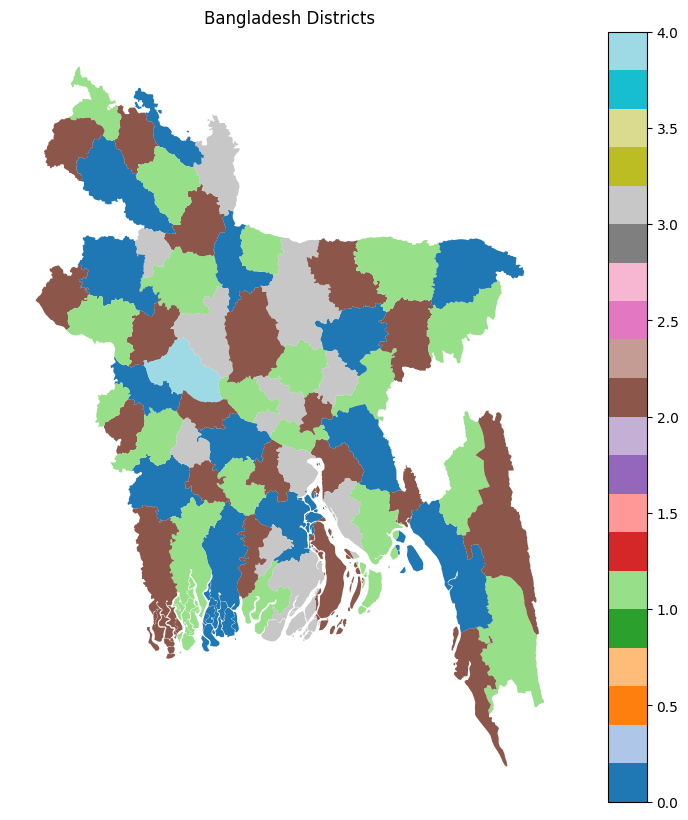

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx

# Read the GeoJSON file
gdf = gpd.read_file('small_bangladesh_geojson_adm2_64_districts_zillas.geojson')

# Create a graph of adjacency
def create_adjacency_graph(geodataframe):
    graph = nx.Graph()
    for idx, geometry in geodataframe.iterrows():
        graph.add_node(idx)
        for neighbor_idx, neighbor_geometry in geodataframe.iterrows():
            if idx != neighbor_idx and geometry.geometry.touches(neighbor_geometry.geometry):
                graph.add_edge(idx, neighbor_idx)
    return graph

# Generate adjacency graph
adj_graph = create_adjacency_graph(gdf)

# Perform graph coloring (minimum colors for adjacent areas)
colors = nx.coloring.greedy_color(adj_graph, strategy="largest_first")

# Add the color information to the GeoDataFrame
gdf['color'] = gdf.index.map(colors)

# Plot the GeoDataFrame with colors
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='color', cmap='tab20', legend=True, ax=ax)
plt.title("Bangladesh Districts")
plt.axis("off")
plt.show()

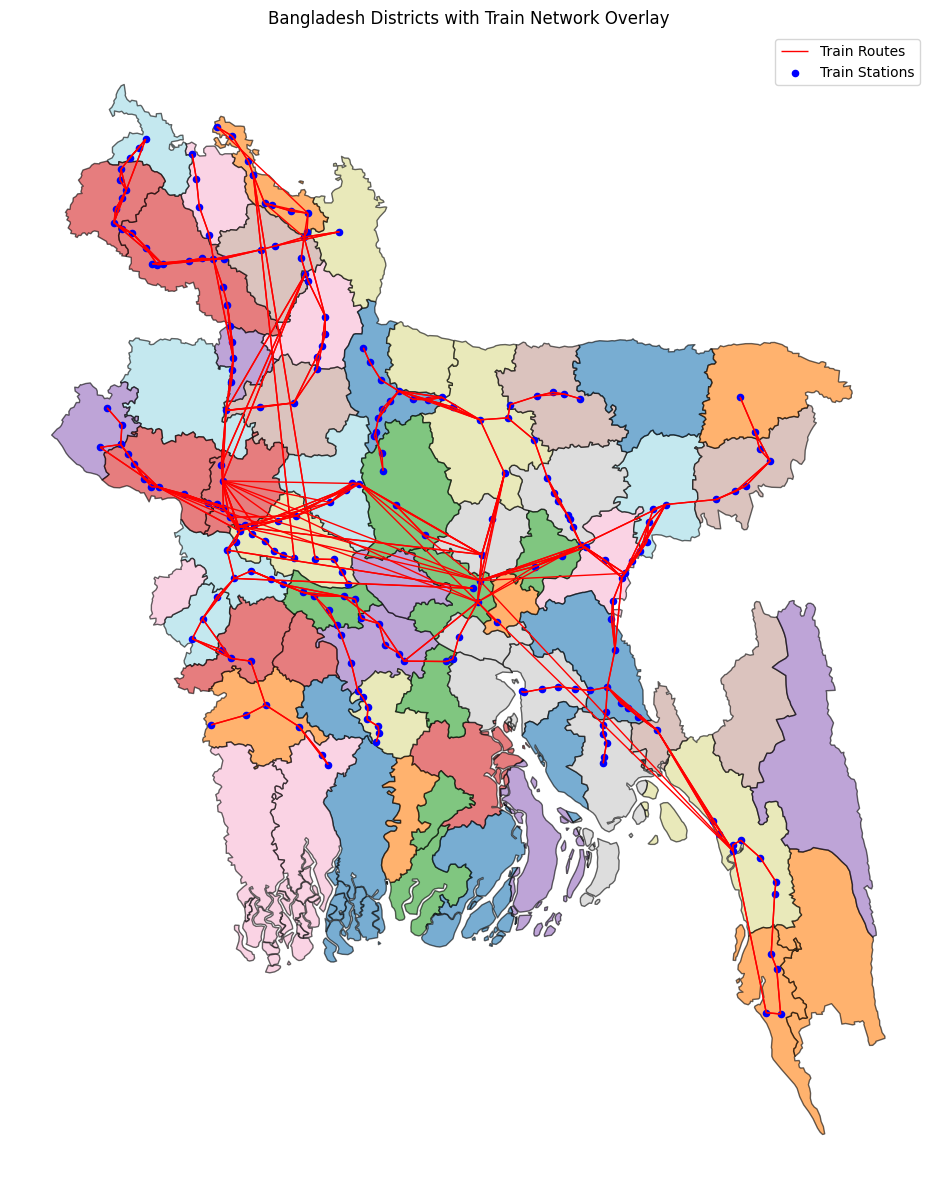

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import Point, LineString

# Step 1: Load GeoJSON file
districts_gdf = gpd.read_file('small_bangladesh_geojson_adm2_64_districts_zillas.geojson')

# Create adjacency-based coloring for districts
districts_gdf['color'] = districts_gdf.index % 10  # Use modulo for coloring

# Step 2: Load train network GEXF file
train_network = nx.read_gexf('train_network_with_coords.gexf')

# Step 3: Extract train stations as GeoDataFrame
nodes = []
for node, data in train_network.nodes(data=True):
    if 'latitude' in data and 'longitude' in data:
        try:
            lat = float(data['latitude'])
            lon = float(data['longitude'])
            nodes.append({'id': node, 'geometry': Point(lon, lat)})
        except ValueError:
            print(f"Invalid coordinates for node {node}, skipping.")
stations_gdf = gpd.GeoDataFrame(nodes)

# Step 4: Extract train routes as GeoDataFrame
edges = []
for u, v in train_network.edges():
    if u in train_network.nodes and v in train_network.nodes:
        u_data = train_network.nodes[u]
        v_data = train_network.nodes[v]
        if 'latitude' in u_data and 'longitude' in u_data and 'latitude' in v_data and 'longitude' in v_data:
            try:
                line = LineString([
                    Point(float(u_data['longitude']), float(u_data['latitude'])),
                    Point(float(v_data['longitude']), float(v_data['latitude']))
                ])
                edges.append({'geometry': line})
            except ValueError:
                print(f"Invalid edge coordinates between {u} and {v}, skipping.")
routes_gdf = gpd.GeoDataFrame(edges)

# Step 5: Plot districts, train stations, and train routes
fig, ax = plt.subplots(figsize=(15, 15))
districts_gdf.plot(column='color', cmap='tab20', legend=False, ax=ax, alpha=0.6, edgecolor='black')
routes_gdf.plot(ax=ax, color='red', linewidth=1, label='Train Routes')
stations_gdf.plot(ax=ax, color='blue', markersize=20, label='Train Stations')

# Add title and legend
plt.title("Bangladesh Districts with Train Network Overlay")
plt.legend()
plt.axis("off")
plt.show()